# High Value Customer Identification (Insiders)

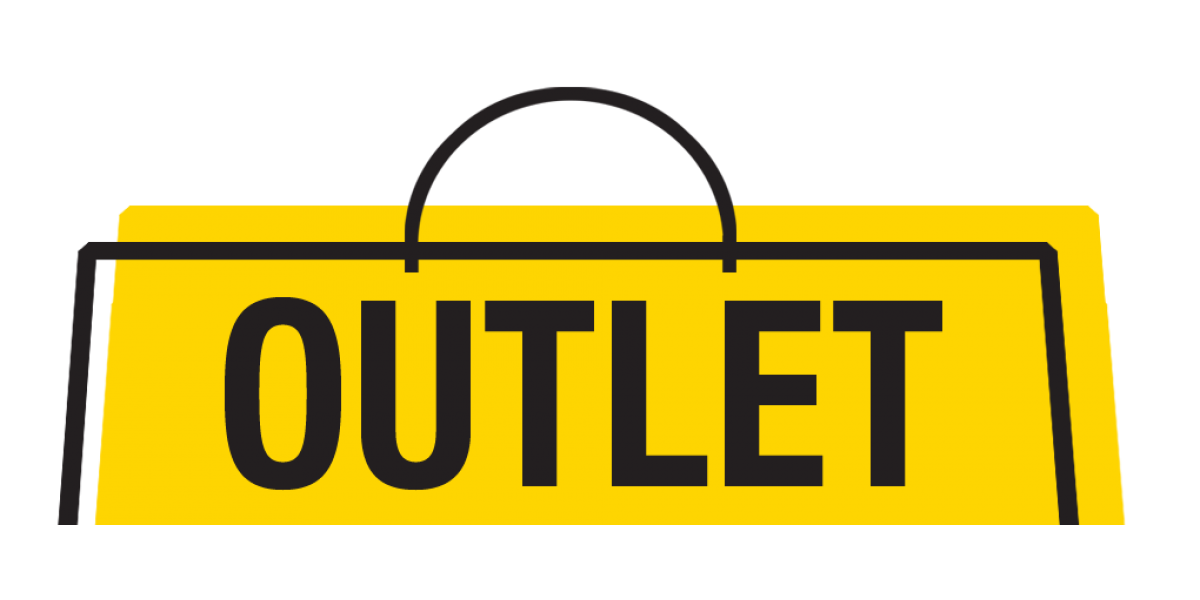

The company All in One Place is a Multibrand Outlet company, i.e., it sells second line products of various brands at a lower price, through an e-commerce platform. In 1 year of operation, the marketing team realized that some customers in its base buy more expensive products with high frequency and end up contributing with a significant portion of the company's revenue. Based on this perception, the marketing team will launch a loyalty program for the best customers in the base, called Insiders. But the team does not have an advanced knowledge of data analysis to choose the program participants. For this reason, the marketing team asked the data team to select eligible customers for the program, using advanced data manipulation techniques.

**Table of contents**

* 0.0. [Imports](#imports)

# Solution Planning (IOT) <a id='solution_planning'></a>

## Input <a id='input'></a>

1. Business Problem
    * Select most valuable customers to join a loyalty program.
2. Dataset
    * E-commerce online sales, for 1 year.

## Output  <a id='output'></a>

1. List of customers who will join the Insiders program.
    * List:
    | client_id | is_insider |
    | ---  | --- |
    | 10323 | yes/1 |
    | 10323 | no/0 |
    
2. Aswer business questions

    1. Who are the people eligible to join the Insiders program?
    2. How many customers will be part of the group?
    3. What are the main characteristics of these customers?
    4. What is the percentage of revenue contribution coming from the Insiders?
    5. What is the expected revenue of this group for the next months?
    6. What are the conditions for a person to be eligible to join Insiders?
    7. How can a person be removed from the Insiders program?
    8. What is the guarantee that the Insiders program is better than the rest of the base ?
    9. What actions can the marketing team take to increase revenue?

## Tasks <a id='tasks'></a>

**1. Who are the people eligible to join the Insiders program?**

* What is being eligible? What are most valuable customers?
* Revenue:
    * High average ticket
    * High LTV (Life Time Value)
    * Low Recency (Las time of purcharse)
    * Big basket size
    * Low churn probability
    * High LTV Prediction
    * High propensity to buy
* Cost:
    * Low return rate
* Shopping experience:
    * High average evaluation

**2. How many customers will be part of the group?**

* Total number of customers
* % of Insiders Group

**3. What are the main characteristics of these customers?**

* Get some customer's characteristics
    * Age
    * Localization

* Get consumption characteristics
    * Clustering attributes

**4. What is the percentage of revenue contribution coming from the Insiders?**

* Anual total revenue
* Insiders' revenue

**5. What is the expected revenue of this group for the next months?**

* Insiders' LTV
* Cohort Analysis

**6. What are the conditions for a person to be eligible to join Insiders?**

* Define model periodicity (1, 3 months)
* The person should be similar to the selected customers.

**7. How can a person be removed from the Insiders program?**

* Define model periodicity (1, 3 months)
* The person should be different to the selected customers.

**8. What is the guarantee that the Insiders program is better than the rest of the base ?**

* Hypothesis Testing
* A/B Testing
* A/B Bayesian Testing

**9. What actions can the marketing team take to increase revenue?**

* Discount
* Purcharse preference
* Shipping
* Company visit

## Solution Benchmark <a id='solution_benchmark'></a>

* RFM Score

<img src="./img/rfm.png" alt="RFM" style="width: 600px;"/>

# 0.0. Imports <a id='imports'></a>

In [116]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans

from IPython.display import HTML

## 0.1. Helper Functions <a id='helper_functions'></a>

In [99]:
def jupyter_settings():
    %matplotlib inline
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

In [100]:
jupyter_settings()

## 0.1. Load dataset <a id='load_dataset'></a>

In [16]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw.drop(df_raw.columns[len(df_raw.columns)-1], axis=1, inplace=True)

In [17]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Data Description <a id='data_description'></a>

In [20]:
df1 = df_raw.copy()

## 1.1. Rename Columns <a id='rename_columns'></a>

In [21]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions <a id='data_dimensions'></a>

In [22]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types <a id='data_types'></a>

In [23]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check Missing Values <a id='check_na'></a>

In [27]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill Missing Values <a id='fill_na'></a>

In [30]:
# remove NA values
df1.dropna(subset = ['description', 'customer_id'], inplace = True)
print('Removed data: {:.2f}'.format( (1 - df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [32]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change DTypes <a id='change_dtypes'></a>

In [35]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [36]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# 2.0. Feature Engineering <a id='feature_engineering'></a>

In [80]:
df2 = df1.copy()

## 2.1. Feature Creation <a id='feature_creation'></a>

In [81]:
# data reference
df_ref = df2.drop(columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country']) \
            .drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [82]:
# Gross Revenue = quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, how = 'left', on = 'customer_id')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = df_ref.merge(df_recency, on = 'customer_id', how = 'left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')

df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3.0. Data Filtering <a id='data_filtering'></a>

In [83]:
df3 = df_ref.copy()

# 4.0. EDA (Exploratory Data Analysis) <a id='eda'></a>

In [84]:
df4 = df3.copy()

# 5.0. Data Preparation <a id='data_preparation'></a>

In [85]:
df5 = df4.copy()

# 6.0. Feature Selection <a id='feature_selection'></a>

In [86]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning <a id='hyperparameter'></a>

In [88]:
X = df6.drop(columns = 'customer_id')

In [119]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within-Cluster Sum of Square <a id='within_cluster'></a>

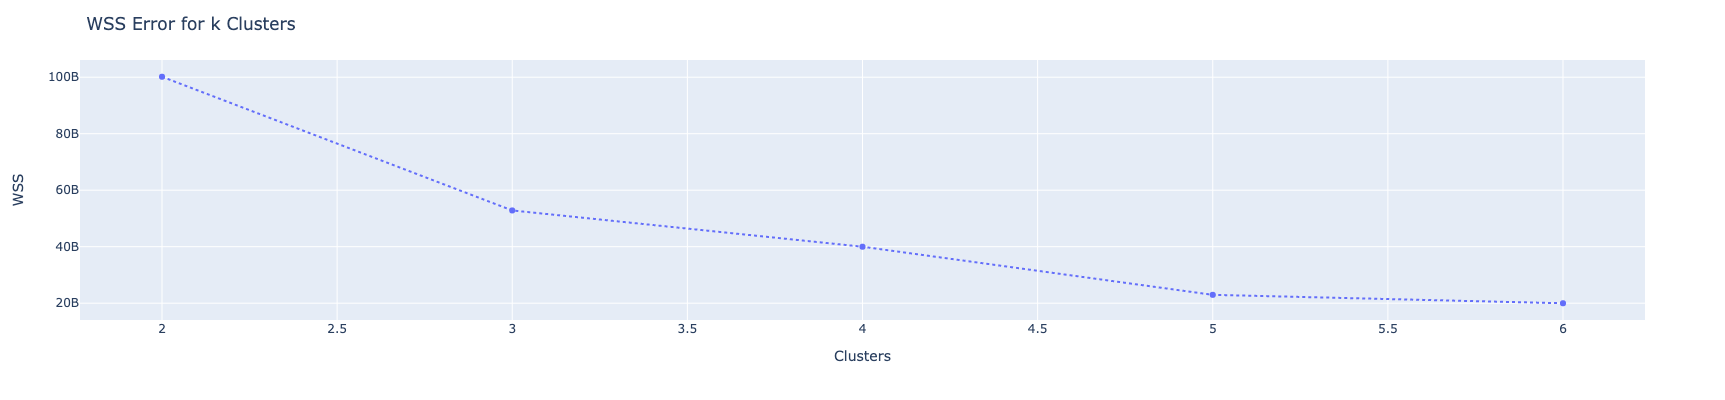

In [120]:
wss = []

for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method
fig = px.line(x=clusters, y=wss, markers = True, width=1200, height=400)
fig.update_layout(title='WSS Error for k Clusters',
                  xaxis_title="Clusters",
                  yaxis_title="WSS")
fig.update_traces(patch={"line": {"dash": 'dot'}}) 
fig.show()

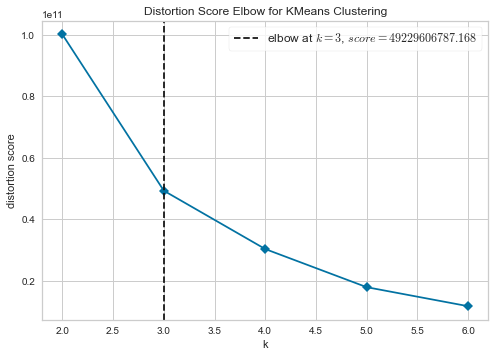

In [124]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings = False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score <a id='sillhouette_score'></a>

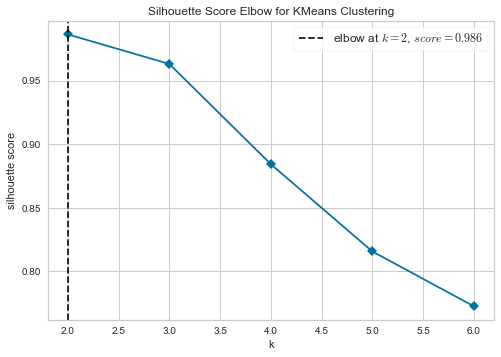

In [127]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric = 'silhouette', timings = False)
kmeans.fit(X)
kmeans.show();

# 8.0. Model Training <a id='model_training'></a>

# 9.0. Cluster Analysis <a id='cluster_analysis'></a>

# 10.0. Deploy to Production <a id='deploy'></a>